In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
import pickle

In [3]:
from src.dataloader import *
# from ilan_src.models import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
from src.evaluation import *

In [23]:
ds_test = pickle.load(open("/datadrive_ssd/saved_datasets/testdataset_single_forecast_only_log_trans_first_days_2.pkl", "rb"))

In [5]:
gan = LeinGANGP.load_from_checkpoint("../models/leingan/1/epoch=120-step=324279-Copy1.ckpt")

In [6]:
gen = gan.gen
gen = gen.to(device)
gen.train(False);

In [24]:
sampler_test = torch.utils.data.SequentialSampler(ds_test)
dl_test = torch.utils.data.DataLoader(
    ds_test, batch_size=64, sampler=sampler_test
)

In [8]:
def plot_samples_per_input(cond, target, gen, k=1, samples = 3):
    fig, axs = plt.subplots(k+1, samples+2, figsize=(15, k*5))
    gen_images = np.zeros((k,samples+2,128,128))
    with torch.no_grad():    
        for i in range(4):
            noise = torch.randn(cond.shape[0], 1, cond.shape[2], cond.shape[3]).to(device)
            pred = gen(cond, noise).detach().cpu().numpy()
            for j in range(k):
                gen_images[j,i,:,:] = pred[j, 0] 

    for j in range(k):
        lr = cond[j, 0].detach().cpu().numpy()
        hr = target[j, 0].detach().cpu().numpy()
        mn = np.min([np.min(hr), np.min(pred), np.min(gen_images[j,i,:,:])])
        mx = np.max([np.max(hr), np.max(pred), np.max(gen_images[j,i,:,:])])
        im = axs[j,0].imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        im = axs[j,1].imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        for i in range(samples):
            im = axs[j,i+2].imshow(gen_images[j,i,:,:], vmin=mn, vmax=mx, cmap='gist_ncar_r')
#             plt.colorbar(im, ax=axs[j,i], shrink=0.7)
    plt.show()  

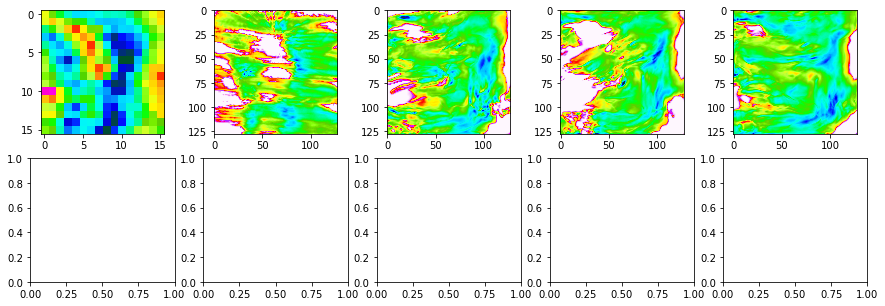

In [9]:
x_sample, y_sample = next(iter(dl_test))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
plot_samples_per_input(x_sample, y_sample, gen, k=1)

## Evaluation

### Get predictions

In [26]:
val_crps, val_rmse = gen_eval(gen, dl_test, 30, ds_test.mins.tp.values, ds_test.maxs.tp.values, ds_test.tp_log, device)

In [27]:
print(val_crps)

0.3336534642027333


In [28]:
print(val_rmse)

0.9353182


## Simple reconstruction generator baseline:

In [5]:
DATADRIVE = '/datadrive_ssd/'
dl_train = pickle.load(open(DATADRIVE+"saved_datasets/trainloader_single_forecast_only_log_trans_full.pkl", "rb"))

In [6]:
gen = StephanGenerator(nres=1, nf_in=1, nf=16, use_noise=True, activation_out='relu'
).to(device)

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [8]:
trainer = Trainer(gen, optimizer, criterion, dl_train)

In [16]:
trainer.fit(50)

Epoch 1:   0%|          | 0/2680 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2680 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
torch.save(gen.state_dict(), f'gen_pretrained.pt')
gen.load_state_dict(torch.load('gen_pretrained.pt'))

<All keys matched successfully>

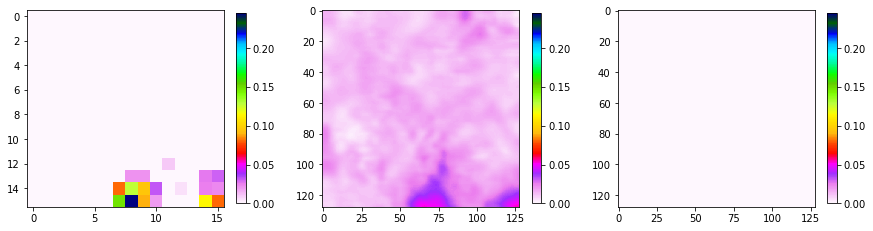

In [20]:
X, y = next(iter(dl_train))
plot_sample_old(X, y, gen, 0)

In [21]:
def gen_eval(gen, dl_test, nens, ds_min, ds_max, tp_log, device):
    """
    gen: generator, which takes (forecast, noise) as arguments
    dl_test: dataloader
    ds_min and ds_max: the min and max values for unscaling
    tp_log: for undoing the log scaling
    """
    crps = []
    rmse = []
    for batch_idx, (x,y) in enumerate(dl_test):
        x = x.to(device)
        preds = []
        for i in range(nens):
            pred = gen(x).detach().to('cpu').numpy().squeeze()
            preds.append(pred)
        preds = np.array(preds).squeeze()
        truth = y.numpy().squeeze()
        truth = xr.DataArray(
                truth,
                dims=['sample','lat', 'lon'],
                name='tp'
            )
        preds = xr.DataArray(
                preds,
                dims=['member', 'sample', 'lat', 'lon'],
                name='tp'
            )

        truth = truth * (ds_max - ds_min) + ds_min

        preds = preds * (ds_max - ds_min) + ds_min
    
        if tp_log:
            truth = log_retrans(truth, tp_log)
            preds = log_retrans(preds, tp_log)
        for sample in range(x.shape[0]):

            sample_crps = xs.crps_ensemble(truth.sel(sample=sample), preds.sel(sample=sample)).values
            sample_rmse = xs.rmse(preds.sel(sample=sample).mean('member'), truth.sel(sample=sample), dim=['lat', 'lon']).values
            crps.append(sample_crps)
            rmse.append(sample_rmse)
    
    
    return np.mean(crps), np.mean(rmse)

In [25]:
val_crps, val_rmse = gen_eval(gen, dl_test, 30, ds_test.mins.tp.values, ds_test.maxs.tp.values, ds_test.tp_log, device)

/anaconda/envs/ilan/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/anaconda/envs/ilan/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/anaconda/envs/ilan/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/anaconda/envs/ilan/lib/python3.9/site-packages/t

In [26]:
print(val_crps)

0.38134070567214323


In [27]:
print(val_rmse)

0.90153366
